In [1]:
# 📌 1. Importer les bibliothèques nécessaires
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
# 📌 2. Charger les datasets
nsl_kdd_path = '../data/NSL-KDD/csv_result-KDDTest+.csv'
cic_ids_path = '../data/CICIDS2017/Monday-WorkingHours.pcap_ISCX.csv'

df_nsl_kdd = pd.read_csv(nsl_kdd_path)
df_cic_ids = pd.read_csv(cic_ids_path)

In [3]:
# 📌 3. Nettoyage des colonnes
def clean_columns(df):
    df.columns = df.columns.str.replace("'", "").str.strip()  # Supprime les apostrophes et espaces inutiles
    return df

df_nsl_kdd = clean_columns(df_nsl_kdd)
df_cic_ids = clean_columns(df_cic_ids)

In [4]:
# 📌 4. Vérification des colonnes
print("NSL-KDD Columns:", df_nsl_kdd.columns.tolist())
print("CIC-IDS Columns:", df_cic_ids.columns.tolist())

NSL-KDD Columns: ['id', 'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'class']
CIC-IDS Columns: ['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean',

In [5]:
# 📌 5. Encodage des labels
label_encoder = LabelEncoder()
df_nsl_kdd['class'] = label_encoder.fit_transform(df_nsl_kdd['class'])
df_cic_ids['Label'] = label_encoder.fit_transform(df_cic_ids['Label'])

In [6]:
# 📌 6. Encodage des variables catégoriques
cat_columns_nsl = ['protocol_type', 'service', 'flag']
cat_columns_cic = []  

label_encoders = {}

for col in cat_columns_nsl:
    le = LabelEncoder()
    df_nsl_kdd[col] = le.fit_transform(df_nsl_kdd[col])
    label_encoders[col] = le  # Sauvegarde pour une éventuelle utilisation future

for col in cat_columns_cic:
    le = LabelEncoder()
    df_cic_ids[col] = le.fit_transform(df_cic_ids[col])
    label_encoders[col] = le

In [7]:
# 📌 7. Sélection des caractéristiques et cibles
X_nsl = df_nsl_kdd.drop(columns=['id', 'class'])  # Supprimer ID et label
y_nsl = df_nsl_kdd['class']

X_cic = df_cic_ids.drop(columns=['Label'])
y_cic = df_cic_ids['Label']

In [8]:
# 📌 8. Vérification et nettoyage des valeurs infinies ou trop grandes
def clean_infinity(X, y):
    # Réinitialiser les index pour aligner X et y
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    
    # Remplacer les infinis par NaN
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Supprimer les lignes contenant des NaN dans X
    mask = X.isna().any(axis=1)
    X = X[~mask]
    y = y[~mask]  # Supprimer les lignes correspondantes dans y
    
    return X, y

# Appliquer le nettoyage à NSL-KDD
X_nsl, y_nsl = clean_infinity(X_nsl, y_nsl)

# Appliquer le nettoyage à CIC-IDS
X_cic, y_cic = clean_infinity(X_cic, y_cic)

In [9]:
# 📌 9. Normalisation des données
scaler = StandardScaler()
X_nsl_scaled = scaler.fit_transform(X_nsl)
X_cic_scaled = scaler.fit_transform(X_cic)

In [10]:
# 📌 10. Division en ensembles d'entraînement et de test
X_train_nsl, X_test_nsl, y_train_nsl, y_test_nsl = train_test_split(X_nsl_scaled, y_nsl, test_size=0.3, random_state=42)
X_train_cic, X_test_cic, y_train_cic, y_test_cic = train_test_split(X_cic_scaled, y_cic, test_size=0.3, random_state=42)

# Vérification des tailles des ensembles
print("Taille de X_train_nsl :", X_train_nsl.shape)
print("Taille de y_train_nsl :", y_train_nsl.shape)
print("Taille de X_train_cic :", X_train_cic.shape)
print("Taille de y_train_cic :", y_train_cic.shape)

Taille de X_train_nsl : (15780, 41)
Taille de y_train_nsl : (15780,)
Taille de X_train_cic : (370636, 78)
Taille de y_train_cic : (370636,)


In [11]:
# 📌 11. Classification avec Random Forest
print("\n🔍 Classification avec Random Forest 🔍")
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_nsl, y_train_nsl)

# Prédictions sur les données de test
y_pred_rf = rf.predict(X_test_nsl)

# Évaluation du modèle
print("Précision : ", accuracy_score(y_test_nsl, y_pred_rf))
print("Matrice de Confusion : \n", confusion_matrix(y_test_nsl, y_pred_rf))
print("Rapport de classification : \n", classification_report(y_test_nsl, y_pred_rf))


🔍 Classification avec Random Forest 🔍
Précision :  0.9874334713187463
Matrice de Confusion : 
 [[3791   51]
 [  34 2888]]
Rapport de classification : 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3842
           1       0.98      0.99      0.99      2922

    accuracy                           0.99      6764
   macro avg       0.99      0.99      0.99      6764
weighted avg       0.99      0.99      0.99      6764



In [12]:
# 📌 12. Classification avec SVM
print("\n🔍 Classification avec SVM 🔍")
svm = SVC(random_state=42)
svm.fit(X_train_nsl, y_train_nsl)

# Prédictions sur les données de test
y_pred_svm = svm.predict(X_test_nsl)

# Évaluation du modèle
print("Précision : ", accuracy_score(y_test_nsl, y_pred_svm))
print("Matrice de Confusion : \n", confusion_matrix(y_test_nsl, y_pred_svm))
print("Rapport de classification : \n", classification_report(y_test_nsl, y_pred_svm))


🔍 Classification avec SVM 🔍
Précision :  0.959491425192194
Matrice de Confusion : 
 [[3756   86]
 [ 188 2734]]
Rapport de classification : 
               precision    recall  f1-score   support

           0       0.95      0.98      0.96      3842
           1       0.97      0.94      0.95      2922

    accuracy                           0.96      6764
   macro avg       0.96      0.96      0.96      6764
weighted avg       0.96      0.96      0.96      6764



In [13]:
from sklearn.model_selection import GridSearchCV

# Optimisation pour Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=3,
    n_jobs=-1
)
grid_search_rf.fit(X_train_nsl, y_train_nsl)

# Meilleur modèle RF
best_rf = grid_search_rf.best_estimator_
print(f"Meilleurs paramètres RF: {grid_search_rf.best_params_}")

# Optimisation pour SVM (À utiliser avec parcimonie - très lent)
param_grid_svm = {
    'C': [0.1, 1],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search_svm = GridSearchCV(
    SVC(random_state=42),
    param_grid=param_grid_svm,
    cv=2,
    n_jobs=-1
)
grid_search_svm.fit(X_train_nsl, y_train_nsl)  # Attention: très long sur gros datasets

# Meilleur modèle SVM
best_svm = grid_search_svm.best_estimator_
print(f"Meilleurs paramètres SVM: {grid_search_svm.best_params_}")

Meilleurs paramètres RF: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Meilleurs paramètres SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [14]:
from sklearn.model_selection import cross_val_score

# Pour Random Forest
cv_scores_rf = cross_val_score(
    best_rf,
    X_train_nsl,
    y_train_nsl,
    cv=5,
    scoring='accuracy'
)
print(f"Scores CV RF: {cv_scores_rf}")
print(f"Moyenne CV RF: {cv_scores_rf.mean():.4f}")

# Pour SVM
cv_scores_svm = cross_val_score(
    best_svm,
    X_train_nsl,
    y_train_nsl,
    cv=3,  # Réduire cv pour gagner du temps
    scoring='accuracy'
)
print(f"Scores CV SVM: {cv_scores_svm}")
print(f"Moyenne CV SVM: {cv_scores_svm.mean():.4f}")

Scores CV RF: [0.98574144 0.98764259 0.98669202 0.9860583  0.98510773]
Moyenne CV RF: 0.9862
Scores CV SVM: [0.96197719 0.96045627 0.95874525]
Moyenne CV SVM: 0.9604


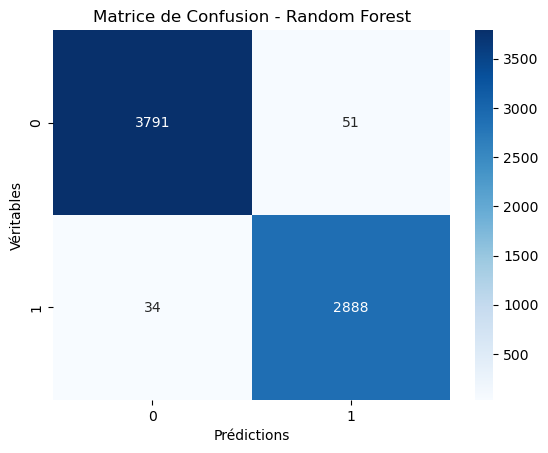

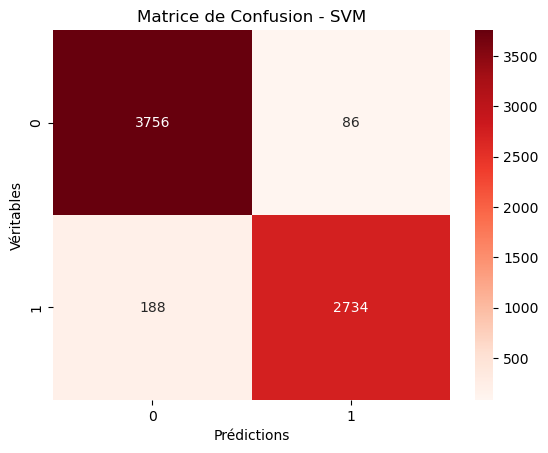

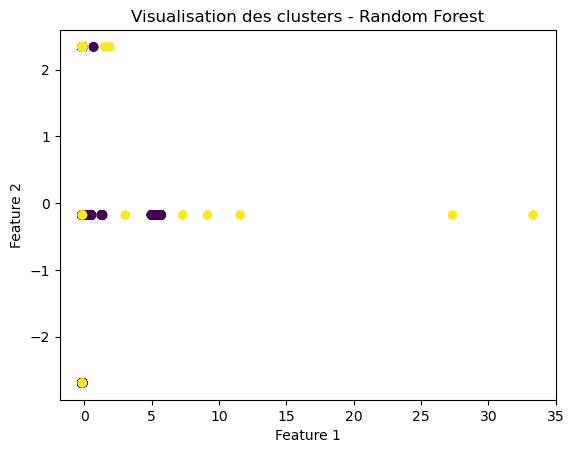

In [15]:
# 📌 13. Visualisation des résultats
# Matrice de confusion pour Random Forest
cm_rf = confusion_matrix(y_test_nsl, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion - Random Forest')
plt.xlabel('Prédictions')
plt.ylabel('Véritables')
plt.show()

# Matrice de confusion pour SVM
cm_svm = confusion_matrix(y_test_nsl, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Reds')
plt.title('Matrice de Confusion - SVM')
plt.xlabel('Prédictions')
plt.ylabel('Véritables')
plt.show()

# Visualisation des clusters (exemple avec 2 features)
if X_nsl.shape[1] >= 2:  # Vérifie qu'il y a au moins 2 features
    plt.scatter(X_test_nsl[:, 0], X_test_nsl[:, 1], c=y_pred_rf, cmap='viridis')
    plt.title('Visualisation des clusters - Random Forest')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

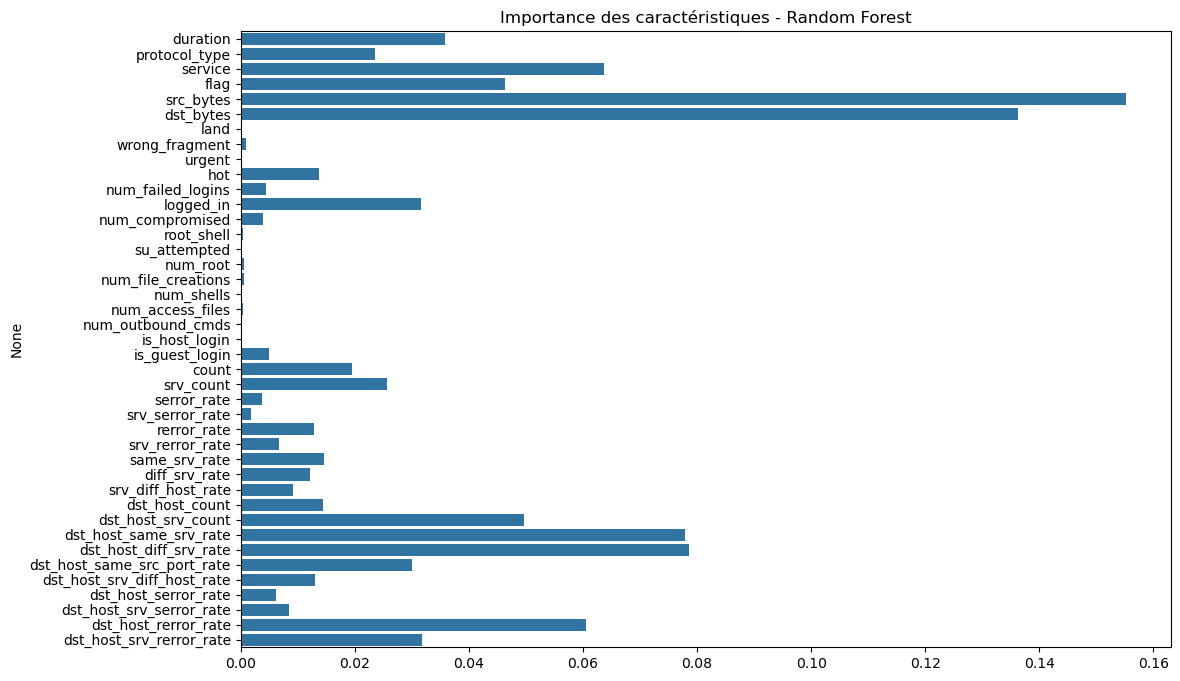

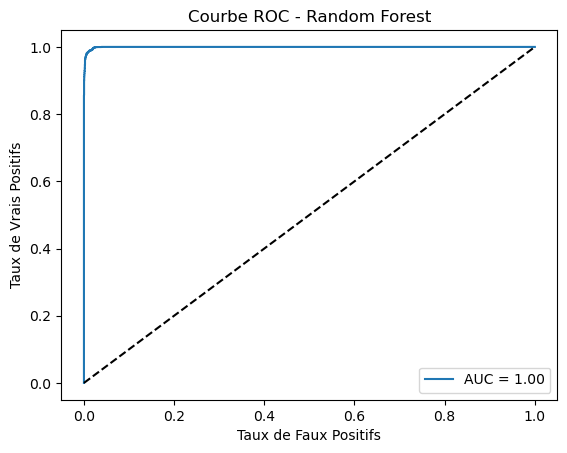

In [16]:
# Feature Importance pour Random Forest
feature_importance = best_rf.feature_importances_
features = X_nsl.columns
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance, y=features)
plt.title('Importance des caractéristiques - Random Forest')
plt.show()

# Courbe ROC (nécessite un probabilités)
from sklearn.metrics import roc_curve, auc

probs = best_rf.predict_proba(X_test_nsl)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_nsl, probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC - Random Forest')
plt.legend(loc="lower right")
plt.show()

In [17]:
import joblib
from datetime import datetime

# Créer un nom de fichier unique
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
joblib.dump(best_rf, f'../models/best_rf_model_{timestamp}.pkl')
joblib.dump(best_svm, f'../models/best_svm_model_{timestamp}.pkl')

['../models/best_svm_model_20250201_2312.pkl']